In [18]:
import jax
jax.config.update("jax_enable_x64", True)
import chex
import jax.numpy as jnp
import sklearn.linear_model
import lovelyplots
import matplotlib.pyplot as plt
plt.style.use("ipynb")

In [19]:
def compute_expected_generalization_error(alpha, lambd, sigma_sq):
    """Compute the expected generalization error according to theory."""

    def compute_k_lambda():
        result = 1 + lambd - alpha
        result += jnp.sqrt((1 + lambd - alpha) ** 2 + 4 * lambd * alpha)
        return result / 2

    k_la = compute_k_lambda()
    return (k_la ** 2 + sigma_sq * alpha) /  ((k_la + alpha) ** 2 - alpha)

In [20]:
def compute_empirical_generalization_error(alpha: float, lambd: float, sigma_sq: float, rng: chex.PRNGKey, N: int = 100) -> float:
    """Fit a linear model and compute the generalization error."""
    P_max = int(2.5 * N)

    rng, x_rng = jax.random.split(rng)
    x = jax.random.normal(x_rng, shape=(P_max, N))
    assert x.shape == (P_max, N)

    rng, w_bar_rng = jax.random.split(rng)
    w_bar = jax.random.normal(w_bar_rng, shape=(N,))
    w_bar *= 1 / jnp.linalg.norm(w_bar)
    assert w_bar.shape == (N,)

    # Compute the labels using target function
    y = jax.vmap(lambda xi: jnp.dot(w_bar, xi))(x)
    assert y.shape == (P_max,)

    rng, eps_rng = jax.random.split(rng)
    eps = jax.random.normal(eps_rng, shape=(P_max,))
    eps *= jnp.sqrt(sigma_sq)
    assert eps.shape == (P_max,)

    # Add noise to the labels
    y += eps

    # Select the first P features
    P = jnp.floor(alpha * N).astype(int)
    mask = jnp.arange(P_max) < P
    x = jnp.where(mask[:, None], x, 0)
    assert x.shape == (P_max, N)
    y = jnp.where(mask, y, 0)
    assert y.shape == (P_max,)

    # Compute the expected solution
    # jax.debug.print("cond={cond}", cond=jnp.logical_or((alpha < 1), (lambd > 0)))
    w_star = jax.lax.cond(
        jnp.logical_or((alpha < 1), (lambd > 0)),
        lambda _: x.T @ jnp.linalg.inv(x @ x.T + N * lambd * jnp.eye(P_max)) @ y,
        lambda _: jnp.linalg.inv(x.T @ x) @ x.T @ y,
        None
    )
    assert w_star.shape == (N,)
    
    # Compute the generalization error
    generalization_error = jnp.linalg.norm(w_star - w_bar) ** 2

    # # Compute the expected generalization error
    # x_test = jax.random.normal(rng, shape=(2000, N))
    # y_test = jax.vmap(lambda xi: jnp.dot(w_bar, xi))(x_test)
    # y_hat = jax.vmap(lambda xi: jnp.dot(w_star, xi))(x_test)
    # expected_generalization_error = jnp.mean((y_test - y_hat) ** 2)
    # print(f"expected_generalization_error={expected_generalization_error}")

    # # Compute the training error
    # training_error = jnp.linalg.norm(x @ w_star - y) ** 2
    # print(f"training_error={training_error}")
    return generalization_error

In [21]:
# vmap + jit the functions to make them faster
expected_generalization_errors_fn = jax.vmap(compute_expected_generalization_error, in_axes=(0, None, None), out_axes=0)
expected_generalization_errors_fn = jax.jit(expected_generalization_errors_fn)

generalization_errors_fn = jax.vmap(compute_empirical_generalization_error, in_axes=(0, None, None, 0), out_axes=0)
generalization_errors_fn_vmapped = lambda alphas, lambd, sigma_sq, rngs: jax.vmap(lambda keys: generalization_errors_fn(alphas, lambd, sigma_sq, keys))(rngs)
generalization_errors_fn_vmapped = jax.jit(generalization_errors_fn_vmapped)

## Figure 3 a)

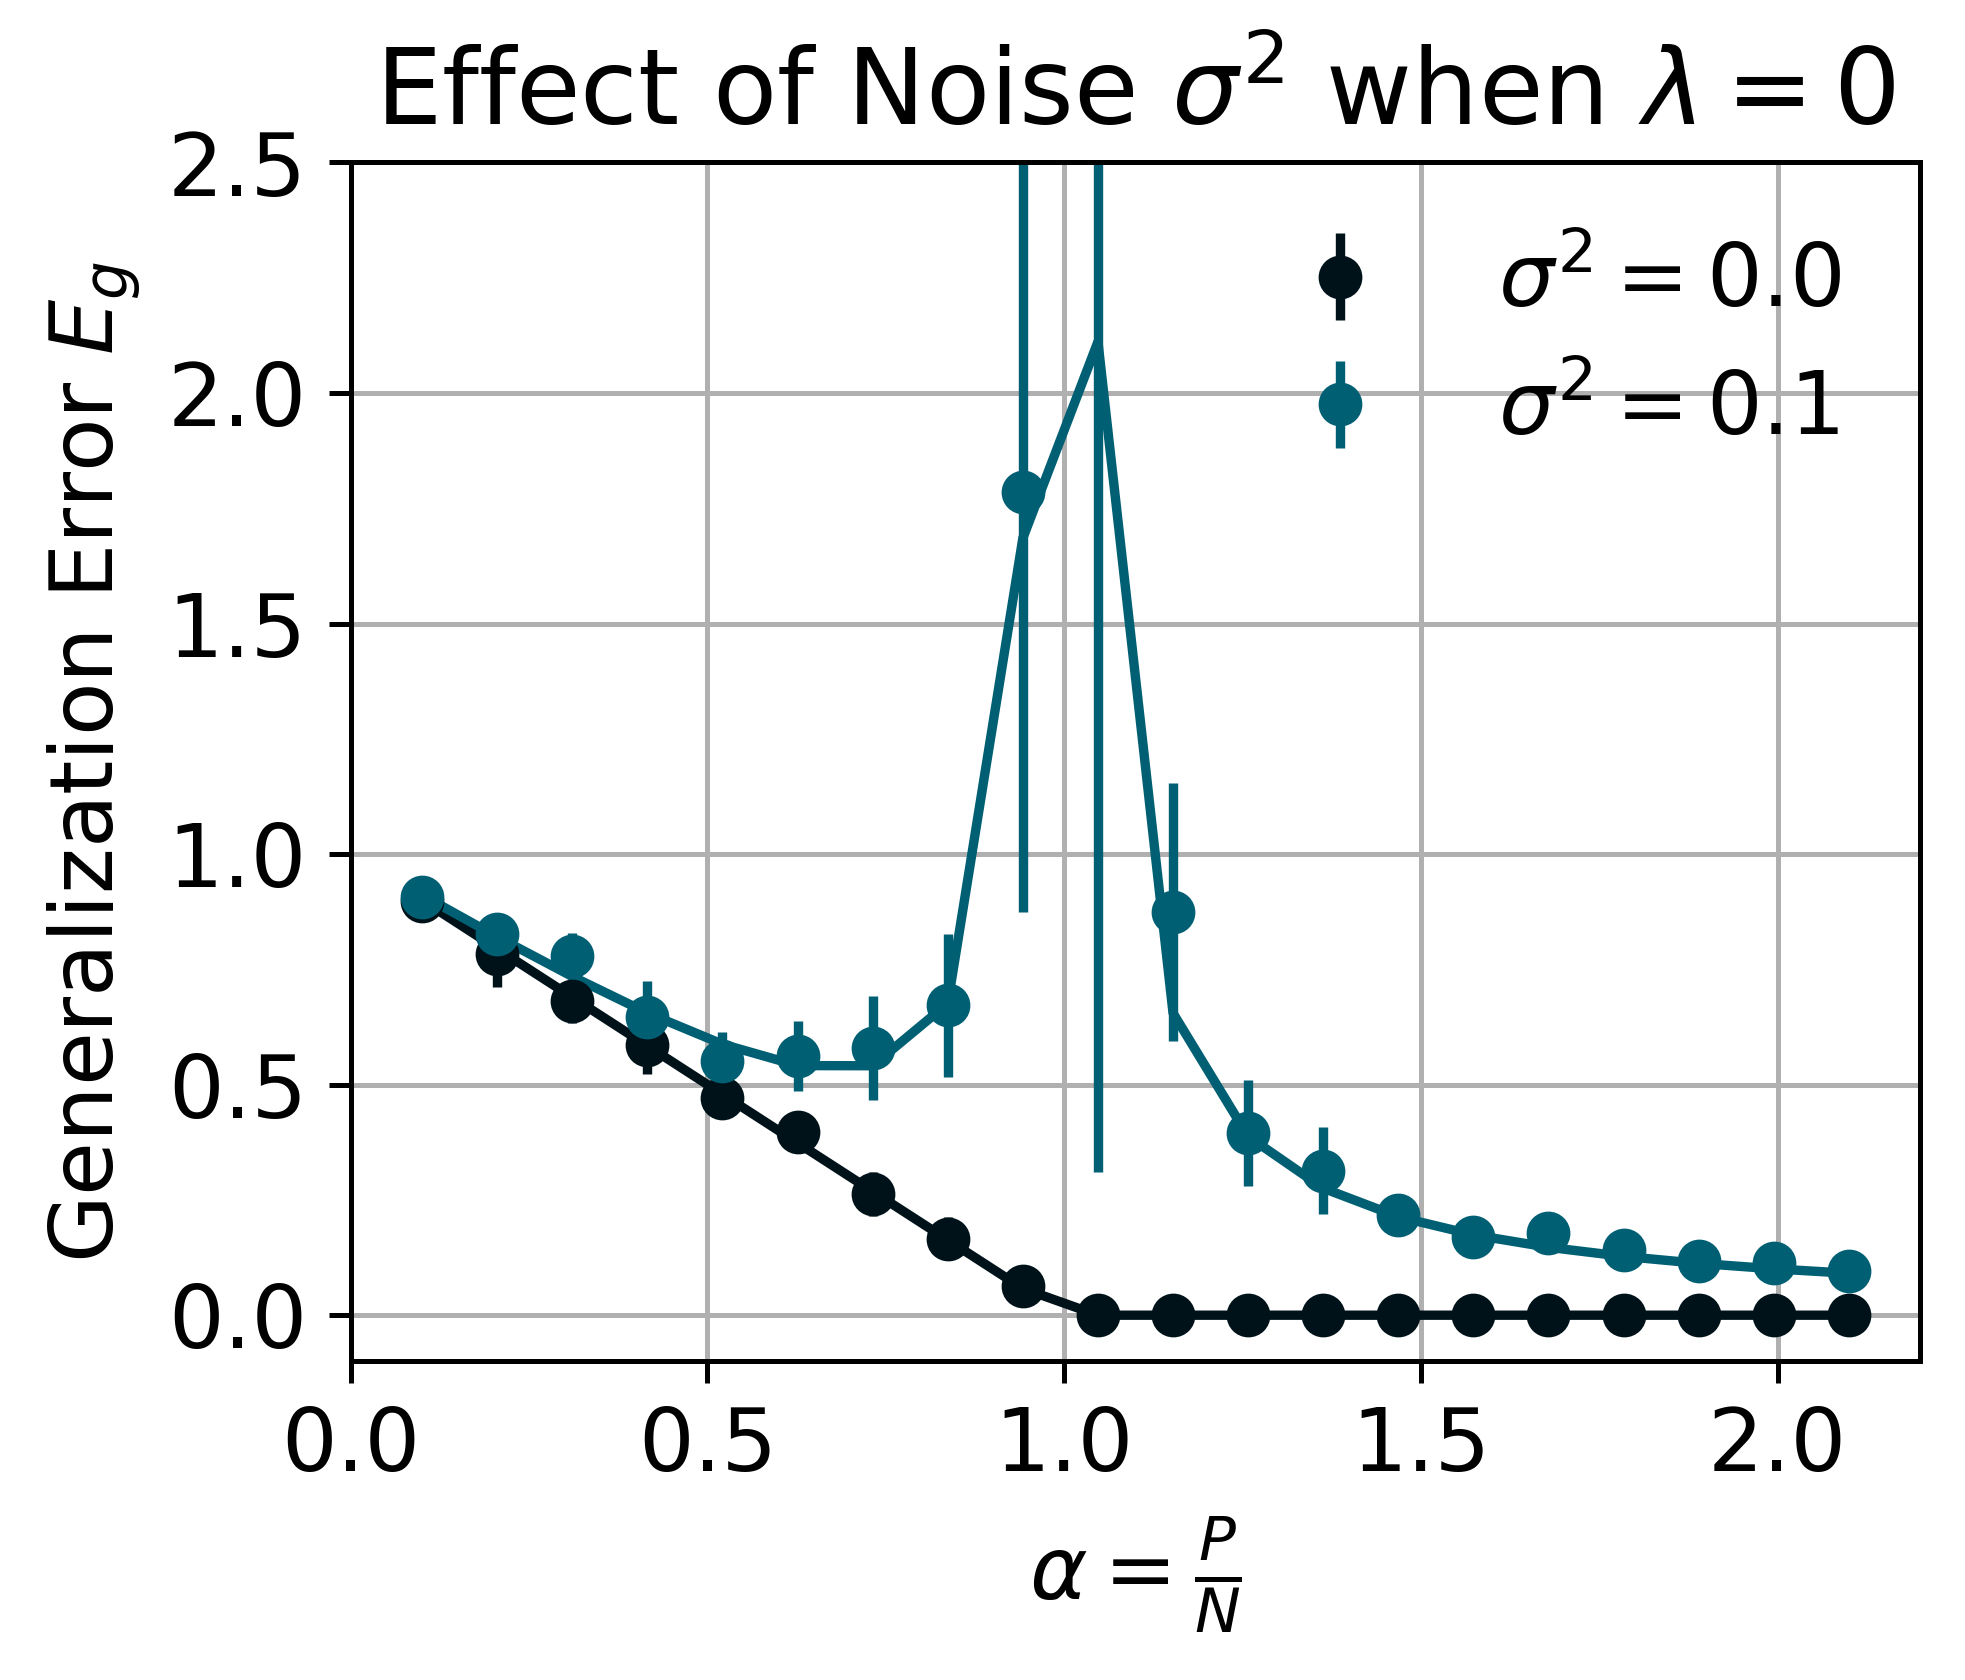

In [22]:
alphas = jnp.linspace(0.1, 2.1, 20)
num_trials = 10

rng = jax.random.PRNGKey(0)
for lambd in [0.]:
    for sigma_index, sigma_sq in enumerate([0., 0.1]):
        lambd = jnp.asarray(lambd)
        sigma_sq = jnp.asarray(sigma_sq)

        expected_generalization_errors = expected_generalization_errors_fn(alphas, lambd, sigma_sq)
        plt.plot(alphas, expected_generalization_errors, '-', c=f"C{sigma_index}")
        
        rng, test_rng = jax.random.split(rng)
        trial_rngs = jax.random.split(test_rng, num_trials)
        trial_rngs = jax.vmap(lambda key: jax.random.split(key, len(alphas)))(trial_rngs)

        generalization_errors = generalization_errors_fn_vmapped(alphas, lambd, sigma_sq, trial_rngs)
        mean_generalization_errors = jnp.mean(generalization_errors, axis=0)
        std_generalization_errors = jnp.std(generalization_errors, axis=0)
        plt.errorbar(alphas, mean_generalization_errors, yerr=std_generalization_errors, fmt='o', label=rf"$\sigma^2 = {sigma_sq}$", c=f"C{sigma_index}")


plt.ylim(-0.1, 2.5)
plt.title(r"Effect of Noise $\sigma^2$ when $\lambda = 0$")
plt.ylabel(r"Generalization Error $E_g$")
plt.xlabel(r"$\alpha = \frac{P}{N}$")
plt.legend()
plt.grid()
plt.show()

## Figure 3 b)

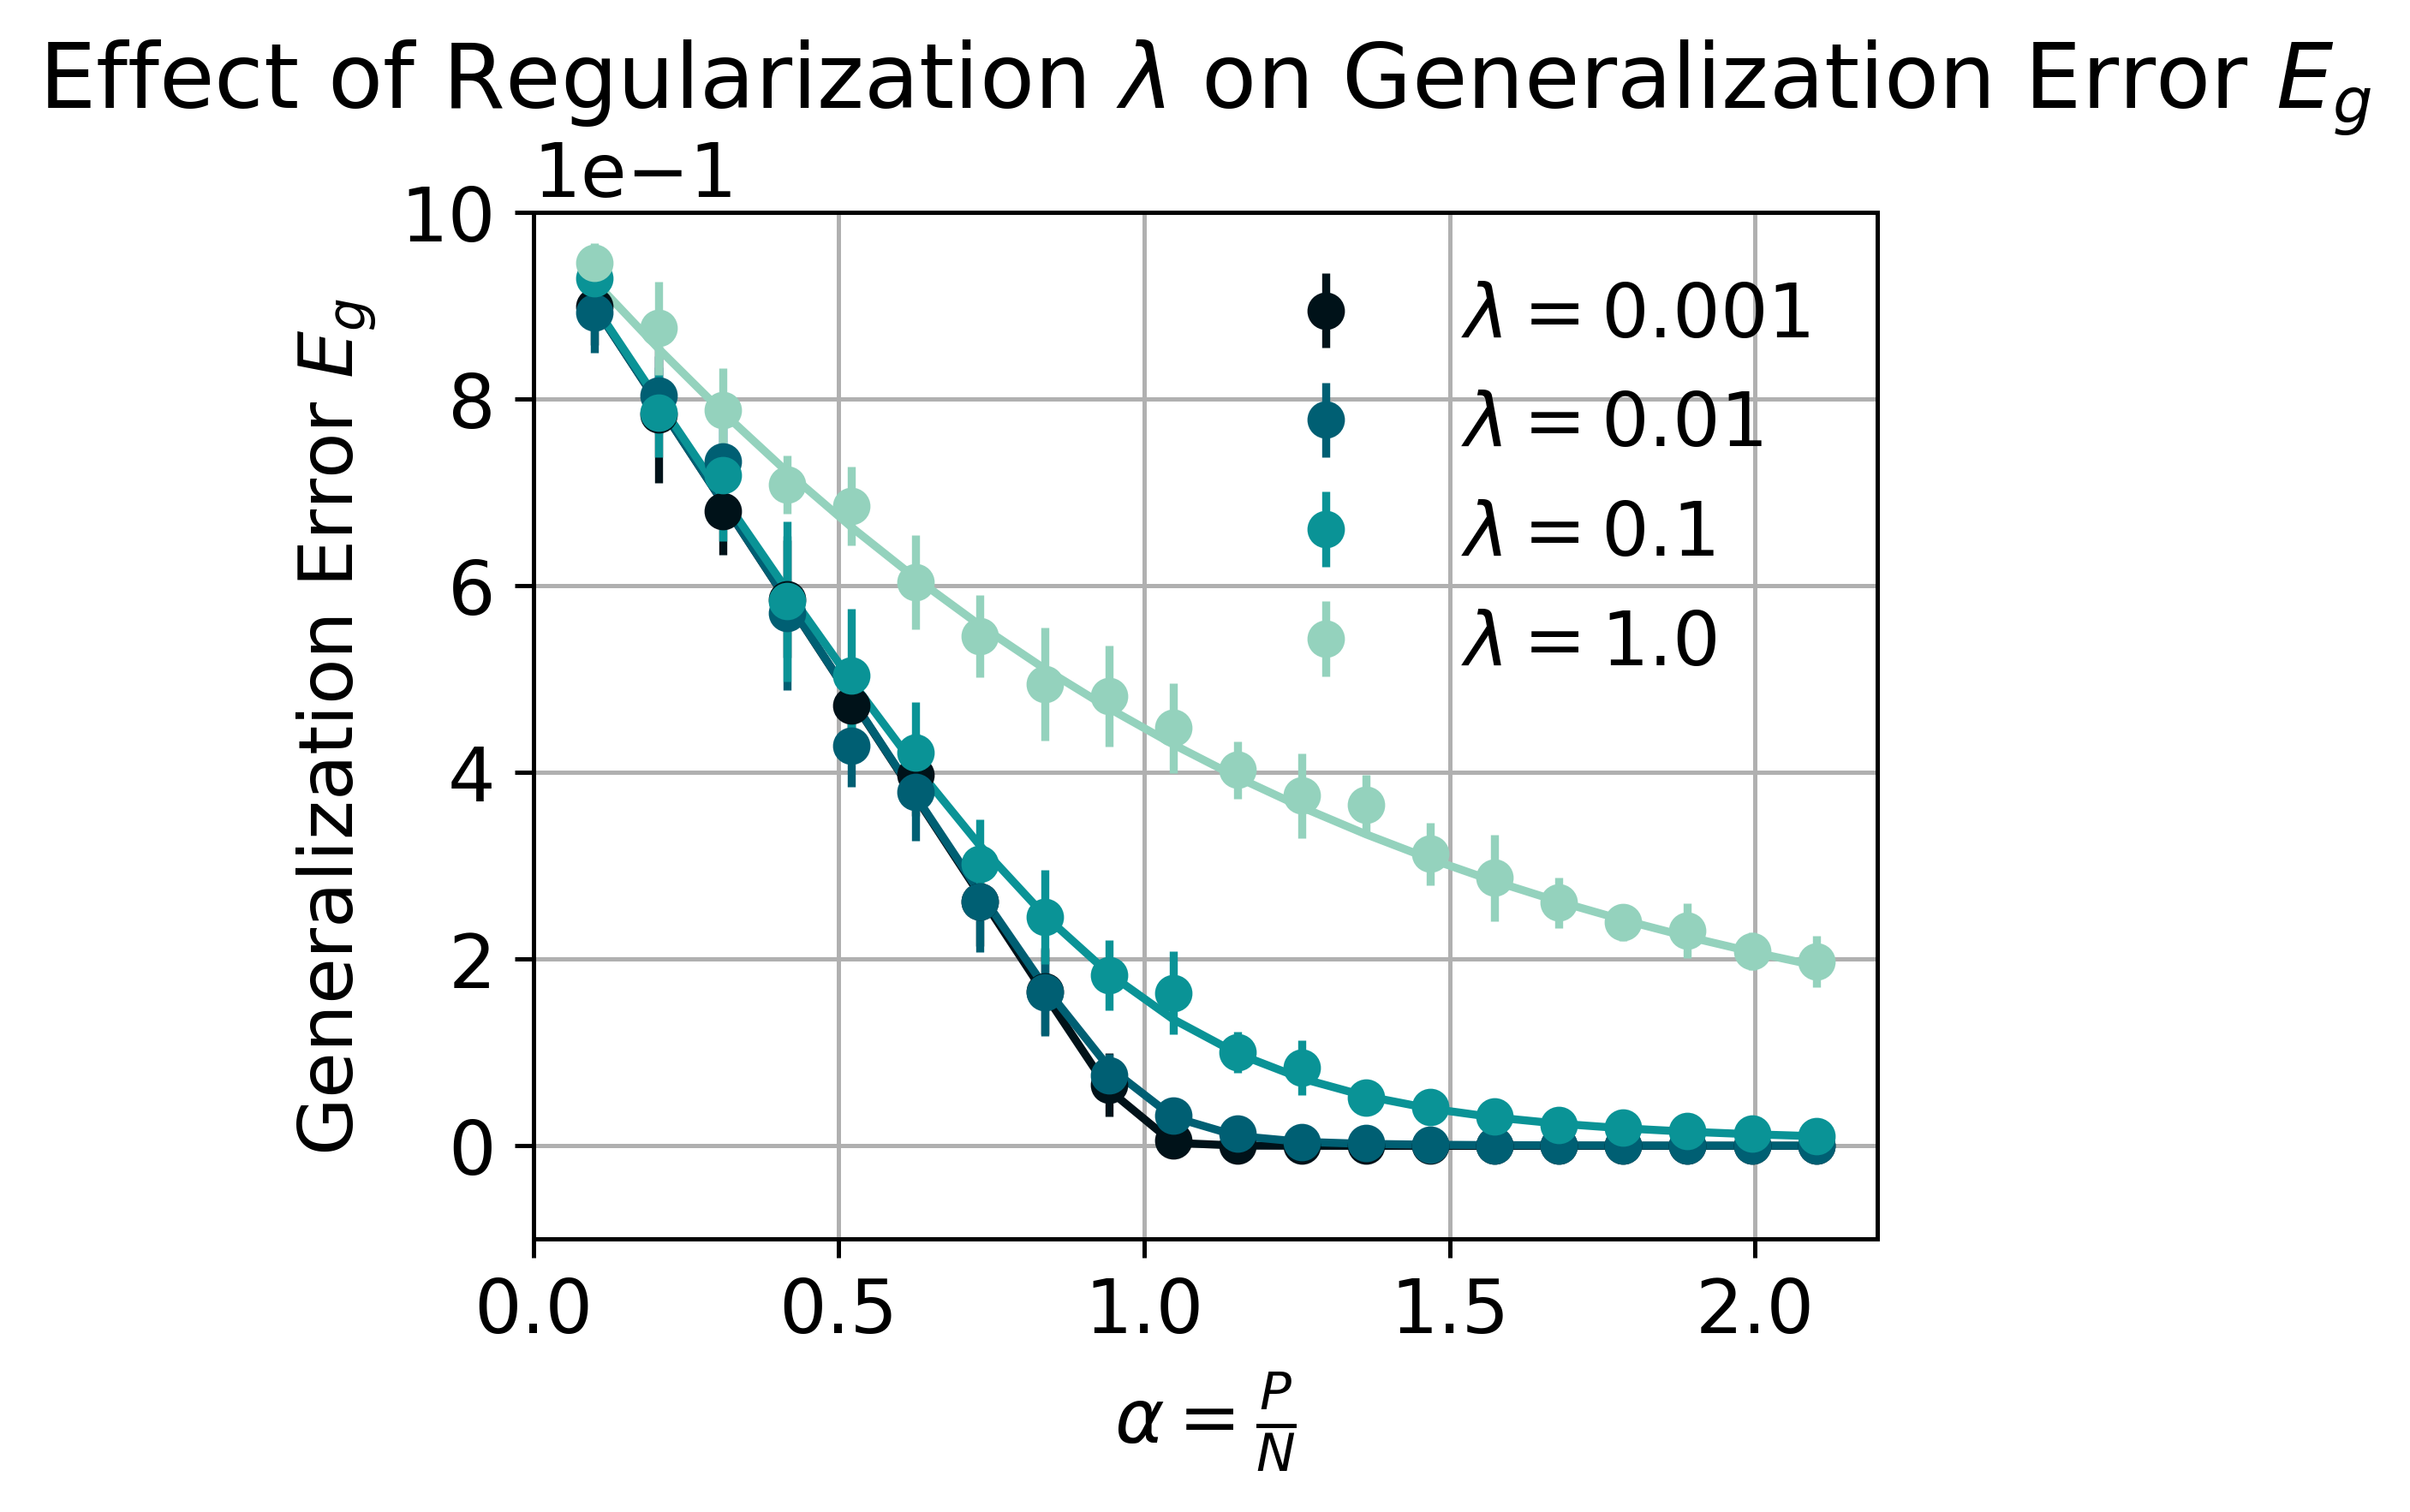

In [23]:
alphas = jnp.linspace(0.1, 2.1, 20)
num_trials = 10

rng = jax.random.PRNGKey(0)
for lambda_index, lambd in enumerate([0.001, 0.01, 0.1, 1.]):
    for sigma_sq in jnp.asarray([0.]):
        lambd = jnp.asarray(lambd)
        sigma_sq = jnp.asarray(sigma_sq)

        expected_generalization_errors = expected_generalization_errors_fn(alphas, lambd, sigma_sq)
        plt.plot(alphas, expected_generalization_errors, '-', c=f"C{lambda_index}")
        
        rng, test_rng = jax.random.split(rng)
        trial_rngs = jax.random.split(test_rng, num_trials)
        trial_rngs = jax.vmap(lambda key: jax.random.split(key, len(alphas)))(trial_rngs)

        generalization_errors = generalization_errors_fn_vmapped(alphas, lambd, sigma_sq, trial_rngs)
        mean_generalization_errors = jnp.mean(generalization_errors, axis=0)
        std_generalization_errors = jnp.std(generalization_errors, axis=0)
        plt.errorbar(alphas, mean_generalization_errors, yerr=std_generalization_errors, fmt='o', label=rf"$\lambda = {lambd}$", c=f"C{lambda_index}")


plt.ylim(-0.1, 1)
plt.title(r"Effect of Regularization $\lambda$ on Generalization Error $E_g$")
plt.ylabel(r"Generalization Error $E_g$")
plt.xlabel(r"$\alpha = \frac{P}{N}$")
plt.legend()
plt.grid()
plt.show()

## Figure 3 c)

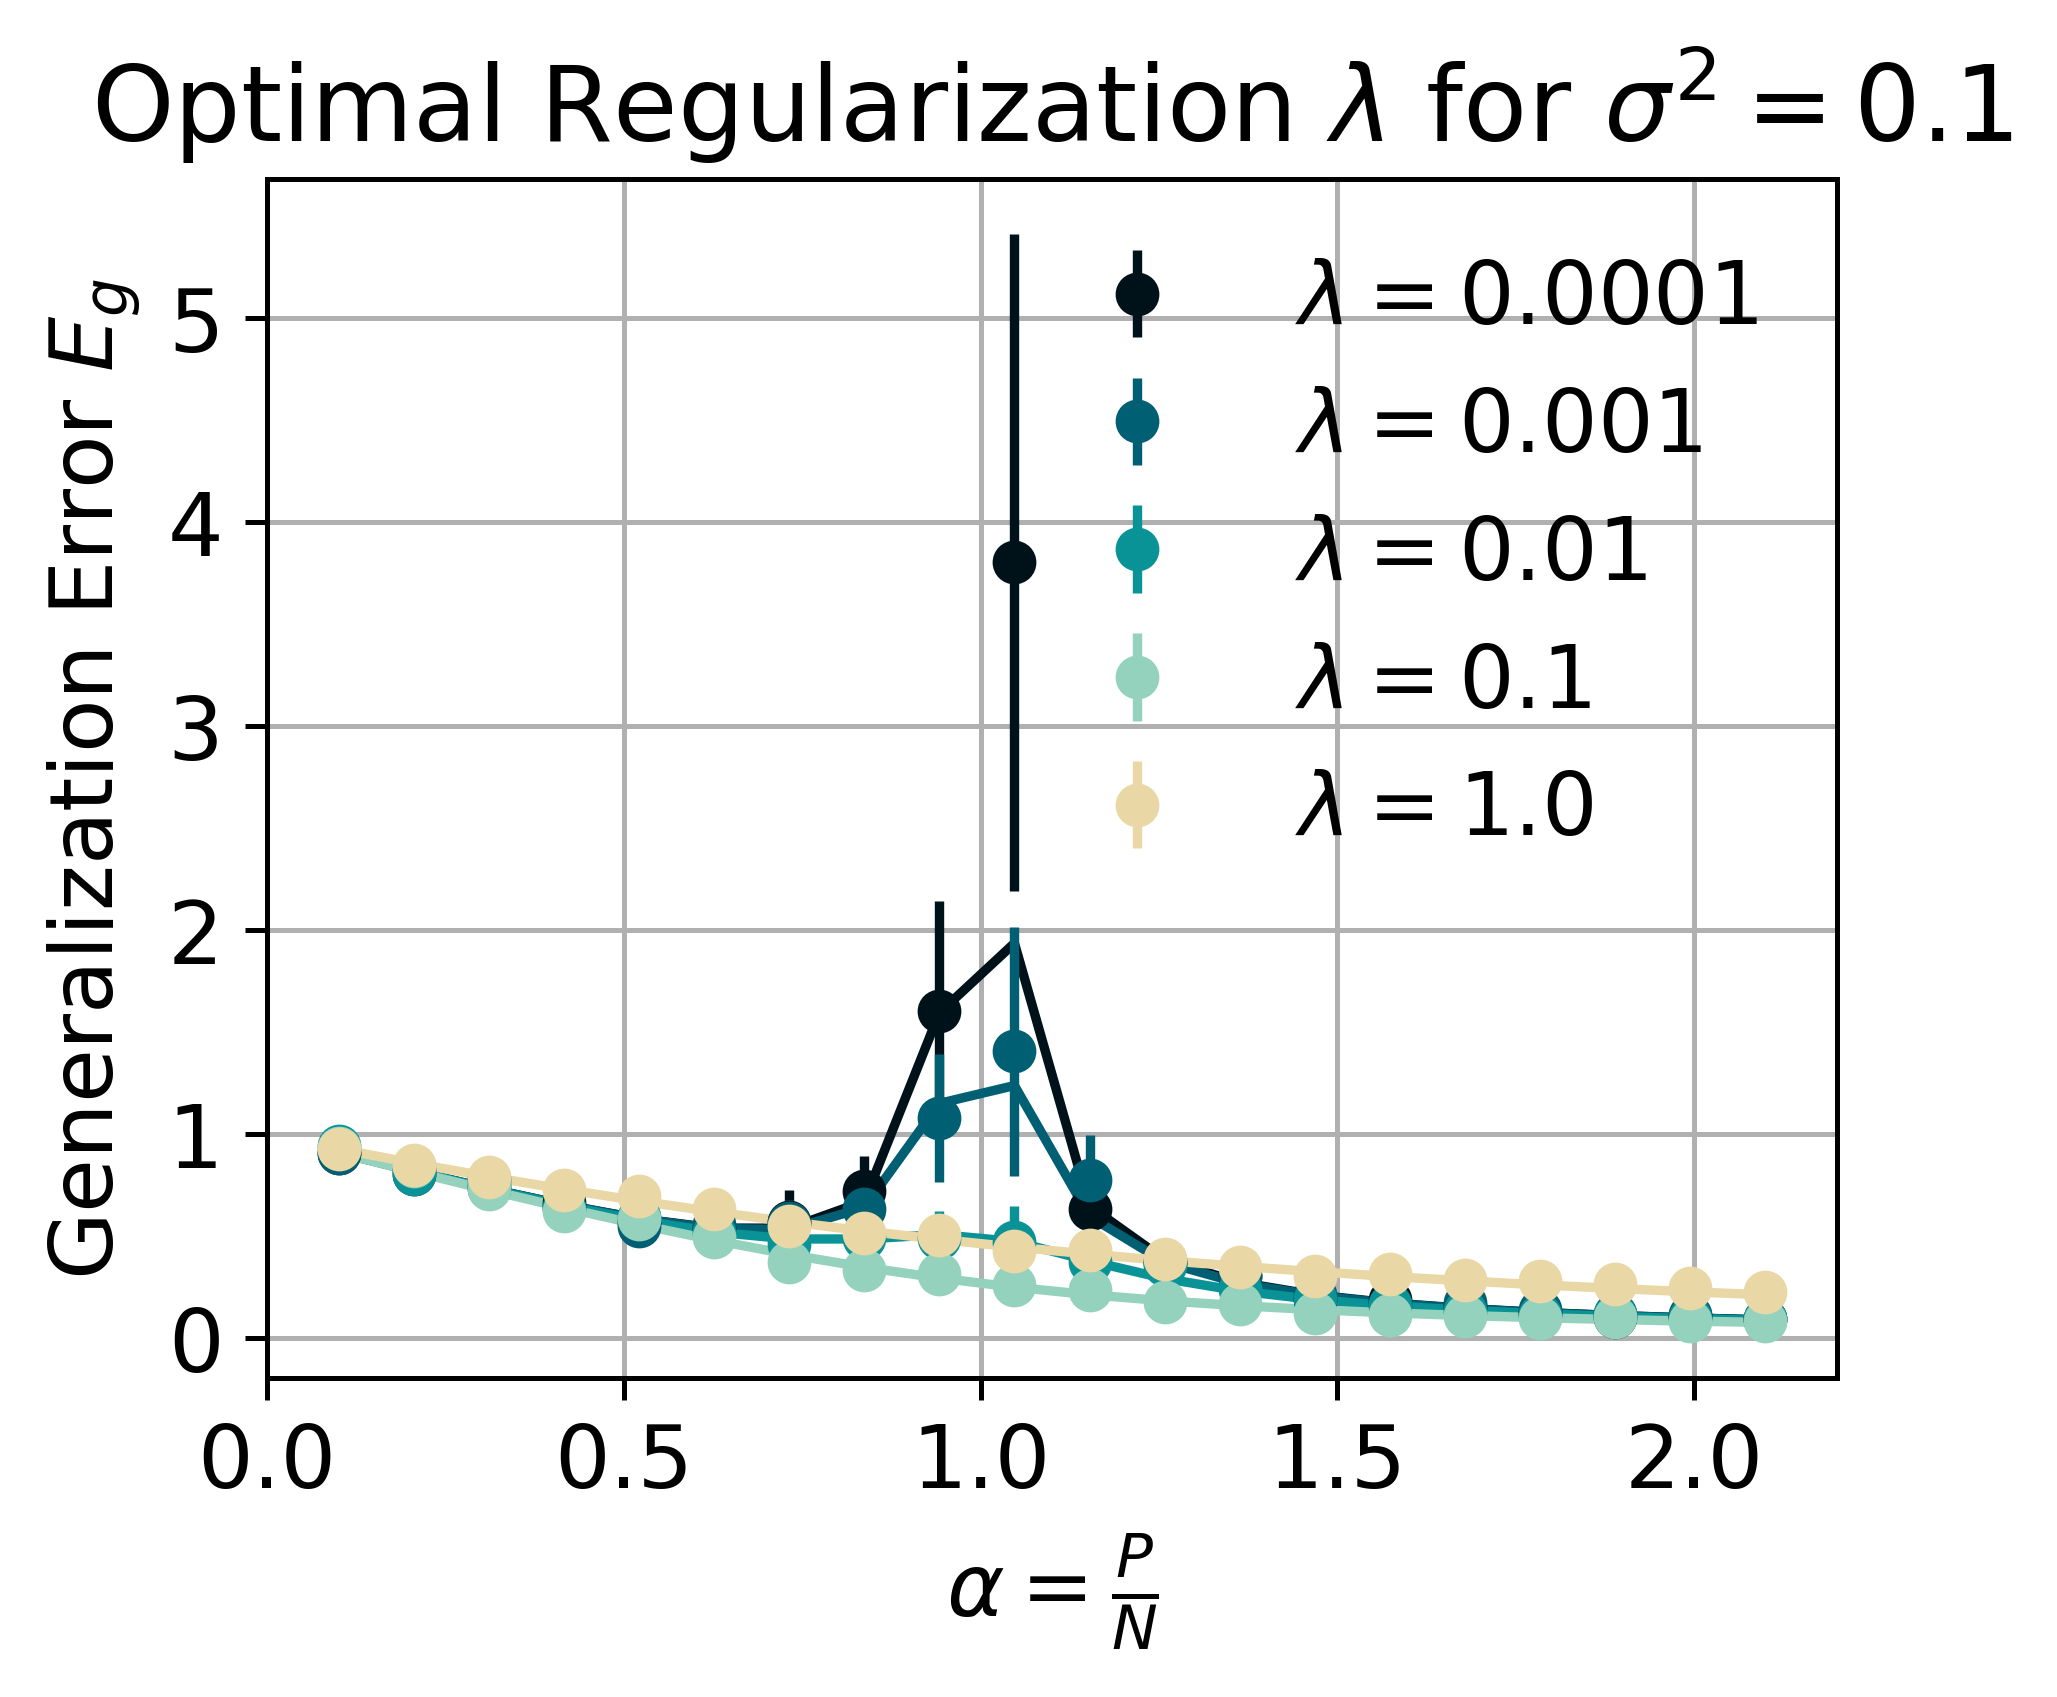

In [24]:
alphas = jnp.linspace(0.1, 2.1, 20)
num_trials = 10

rng = jax.random.PRNGKey(0)
for lambda_index, lambd in enumerate([0.0001, 0.001, 0.01, 0.1, 1.]):
    for sigma_sq in [0.1]:
        lambd = jnp.asarray(lambd)
        sigma_sq = jnp.asarray(sigma_sq)

        expected_generalization_errors = expected_generalization_errors_fn(alphas, lambd, sigma_sq)
        plt.plot(alphas, expected_generalization_errors, '-', c=f"C{lambda_index}")
        
        rng, test_rng = jax.random.split(rng)
        trial_rngs = jax.random.split(test_rng, num_trials)
        trial_rngs = jax.vmap(lambda key: jax.random.split(key, len(alphas)))(trial_rngs)

        generalization_errors = generalization_errors_fn_vmapped(alphas, lambd, sigma_sq, trial_rngs)
        mean_generalization_errors = jnp.mean(generalization_errors, axis=0)
        std_generalization_errors = jnp.std(generalization_errors, axis=0)
        plt.errorbar(alphas, mean_generalization_errors, yerr=std_generalization_errors, fmt='o', label=rf"$\lambda = {lambd}$", c=f"C{lambda_index}")


plt.title(r"Optimal Regularization $\lambda$ for $\sigma^2 = 0.1$")
plt.ylabel(r"Generalization Error $E_g$")
plt.xlabel(r"$\alpha = \frac{P}{N}$")
plt.legend()
plt.grid()
plt.show()